**Lesson 9 – MNIST classifier**

Build a mnist classifier.

Build a mnist classifier:

1. [Get `MINST` data](#ds)
1. [Explore data](#ed)
1. [Split the datasets into a training set and a test set](#split)
1. [Build a digit classifier](#build)
1. [Compute performance metrics](#metrics)
1. [Compare ML techniques](#compare)
1. [Multiclass classification](#multi_class)
1. [Error](#error)
1. [Multilabel classification](#multi_label)

In [1]:
%run setup.ipynb

## 1. Get `MNIST` data  <a class='anchor' id='ds'></a>

`MNIST` is a set of 70000 small images of digits hand written by high school students and employees of the US Census Bureau.
* Each image is `labeled` with the digit it represents.
* Each image has `784 = 28x28` features. 
* Each image is composed of `28x28` pixels. 
* Each feature represents one pixel's intensity from 0 (white) to 255 (black).

This dataset is considered the `hello world` of Machine Learning, and used to test new classification algorithm.

To download `MINST` dataset, we use [fetch_openml()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) with `as_frame=False` to avoid having returned a Pandas `DataFrame` by default.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

type(mnist)

sklearn.utils.Bunch

## 2. Explore data  <a class='anchor' id='ed'></a>

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* the `DESCR` key describes the dataset
* the `data` key contains an array with one row per instance and one columns per feature
* the `target` key contains an array with the labels

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

MNIST has 70000 images with 784 features.

In [6]:
y.shape

(70000,)

In [7]:
type(X)

numpy.ndarray

In [8]:
type(y)

numpy.ndarray

Let's look at one digit from the dataset:

* consider an instance's feature vector
* [reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) it to a 28 x 28 array
* display it with [imshow()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
* define a `plot_digit()` function 

In [9]:
some_digit = X[0]
print(f'{some_digit}')

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

In [10]:
some_digit_image = some_digit.reshape(28, 28)

Saving figure some_digit_plot


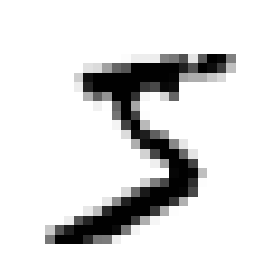

In [11]:
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

The image is similar to 5. 

In [12]:
y[0]

'5'

 This is confirmed by the `y[0]` label that is a string, therefore it can be casted to integer (mainly because ML algorithms ususally expect numbers).

In [13]:
y = y.astype(np.uint8)

`plot_digit()` is the function defined to plot a single digit.

In [14]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Use `plot_digit()` function to plot a different digit.

Saving figure more_digit_plot


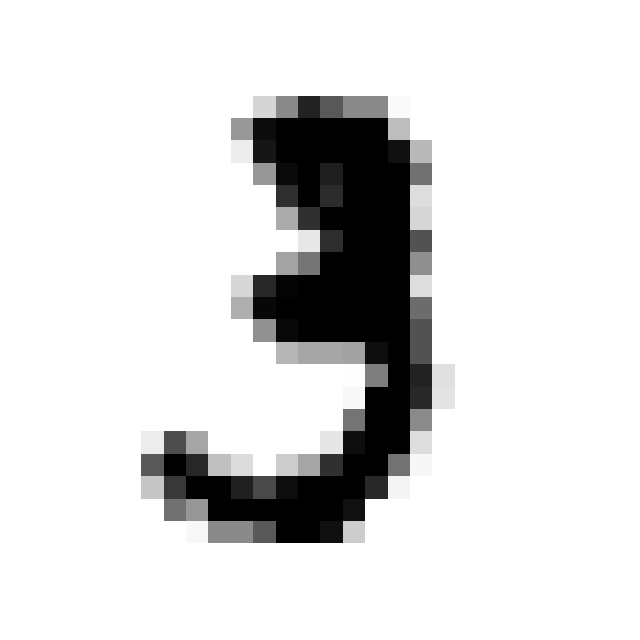

In [15]:
plt.figure(figsize=(9,9))
example_images = X[10]
plot_digit(example_images)
save_fig("more_digit_plot")
plt.show()

In [16]:
y[10]

3

Use a more complicated `plot_digit()` function to plot a more images.

In [17]:
import plot_digits as pltd

Saving figure more_digits_plot


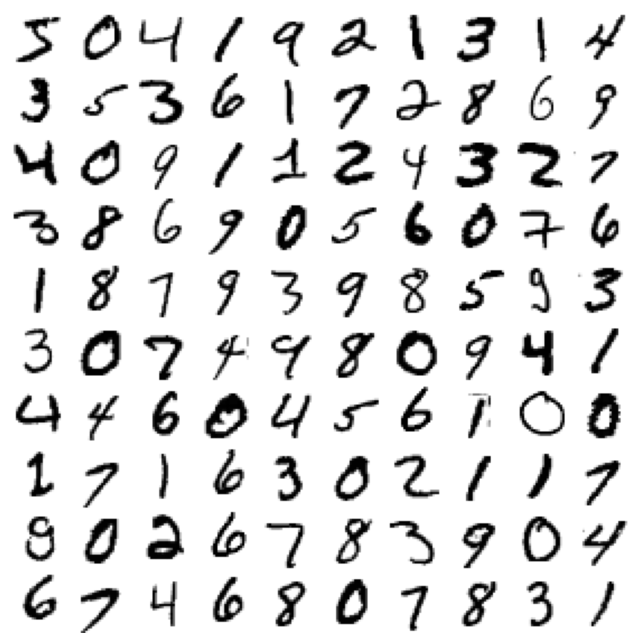

In [18]:
plt.figure(figsize=(9,9))
example_images = X[:100]
pltd.plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

## 3. Split the datasets into a training set and a test set  <a class='anchor' id='split'></a>

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Get the first 60000 images for the training set and the last 10000 images for the test set. The training set is already shuffled guaranteeing not to have many similar instances in a row.

## 4. Training a Binary Classifier  <a class='anchor' id='build'></a>

Try to identify one digit, i.e. the number 5. The idea is to build a binary classifier able to distinguish between `two` classes, `5` and `not-5`.

Define the vectors for this classification task.

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's try a [`Stochastic Gradient Descent (SGD)` classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) that implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification. 

This algorithm has shown to be capable of handling very large datasets efficiently, because `SGD` deals with training instances independently, one at a time.

* SGD relies on randomness during training, and to reproduce results `random_state` must to be set.

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

We can the `sgd_clf` classifier to detect images of the number 5.

In [22]:
sgd_clf.predict([some_digit])

array([ True])

The classifer guess that this image represents a 5 (True). It guessed right. Let's evaluate this model.

## 5. Performance Measures <a class='anchor' id='metrics'></a>

To evaluate a model there is the `k-fold cross-validation` process: the training set is split into `k` folds and the procedure makes predictions and evaluates them on each fold using a model trained on the remaining folds.

Try with `k=3` folds and detect model's `accuracy`. 

### 5.1 Accuracy <a class='anchor' id='acc'></a>

In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

No bad! Almost 95%. But how does each classifier behave to classify every single image in the `not-5` class?

In [24]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The `accuracy` is over 90%. This is because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right 90% of the time.

`Accuracy is not always a good performance metric for classifiers, especially when you are dealing with skewed datasets.`

### 5.2 Confusion Matrix  <a class='anchor' id='conf'></a>

A better way to look at the performance of a classifier is to look at the `confusion matrix`. 
* It counts the number of times instances of class `A` are classified as class `B`.
* It is possible to determine the number of times the classifier confused images of `5s` with `3s`.

To compute the confusion matrix you need to have a set of predictions to be compared to the actual targets. You can compute the prediction with the `cross_val_predict()` function that performs `k`-fold cross validation, but it returns the predictions made on each test fold.

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

You can get the confusion matrix with the `y_train_5` target classes and the `y_train_pred` predicted classes.

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The confusion matrix is characterized by actual (row) and predicted (column) classes.

The first row considers non-5 images (the negative class): 
* 53892 were correctly classified as non-5s (true negatives)
* 687 were wrongly classified as 5s (false positive)

The second row considers 5s images (the positive class):
* 1891 were wrongly classified as non-5s (false negative)
* 3530 were correctly classified as 5s (true positive)

A perfect classifier would have only `true positives` and `true negatives`, so the confusion matrix would have non zero values only on its main diagonal.

In [28]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

More concise metrics.

### 5.3 Precision and Recall <a class='anchor' id='pr'></a>

In [29]:
from sklearn.metrics import precision_score, recall_score

The `precision` metric is the accuracy of the positive predictions. 
* TP/(TP+FP)
* TP is the number of true positives. FP is the number of false positives.

In [30]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [31]:
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

[[53892   687]
 [ 1891  3530]]


0.8370879772350012

In addition to the precision metric, there is the `recall` metric or `sensitivity` metric or true positive rate. This metric provides the ratio between positive instances that are correctly detected by the classifier.
* TP/(TP+FN)
* FN is the number of false negatives.

In [32]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [33]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

According to the precision and recall metrics, the `5` classifier represents a `5` only for the `83%` of the time, only detecting `65%` of the 5s.

In addition to the precision and recall metrics, there is `f1-score` that is the `harmonic mean` of precision and recall. 
* 2 x (precision x recall)/(precision + recall)

It gives much more weight to low values.

The classifier will get a high `f1-score` if both `recall` and `precision` are high.

`f1-score` favors classifiers that have similar precision and recall. This is not always what you wish.
e.g. if you have to detect videos that are safe for kids, you would prefer classifiers that reject good videos (low recall) and keep save ones (high precision).

In [34]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [35]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### 5.4 Precision/Recall trade-off <a class='anchor' id='prto'></a>

In some contexts you care about precision, in some others you prefer recall.

F1-score depends on prevision and recall values. Increasing precision, reduces recall and viceversa. It is a matter of a `precision/recall trade-off`.

The SGDClassifier makes its classification decisions according to a score based on a `decision function`. 
* if the score is greater than a threshold, it assigns the instance to the positive class
* otherwise it assigns it to the negative class
According to the threshold you can increase precision and reduce recall or viceversa.

Scikit learn does not let you set the threshold, but you can act on the decision scores that it uses to make predictions. 
* You can use `decision_function` instead of the `predict` function.
* You can make a prediction based on the scores.

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

SGDClassifier uses a threshold equal to 0. 

In [38]:
y_some_digit_pred

array([ True])

The code retuns the same result as the `predict` function. In case we raise threshold to 8000.

In [39]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The recall is decreased. The image actually represents a 5 and the classifier detects it with threshold 0, but it misses it when the threshold is increased to 8000.

How can we set this threshold?
1. Use `cross_val_predict()` function to get `decision_function` scores of all instances in the training set
1. Use `precition_recall_curve()` function to compute precision and recall thresholds

In [40]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") # returns decision scores

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

0.4799852425751706
Saving figure precision_recall_vs_threshold_plot


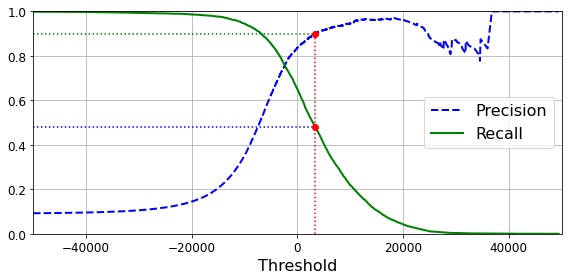

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

#np.argmax returns the indices of the maximum values along an axis.    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] 
print(recall_90_precision)
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "g:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "b:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

The precision can go down when the thrashold raises, while the recall can go down when the threshold is increased.

In [43]:
(y_train_pred == (y_scores > 0)).all()

True

Other ways to select a good precision/recall trade-off is:
* Plotting precision against recall

Saving figure precision_vs_recall_plot


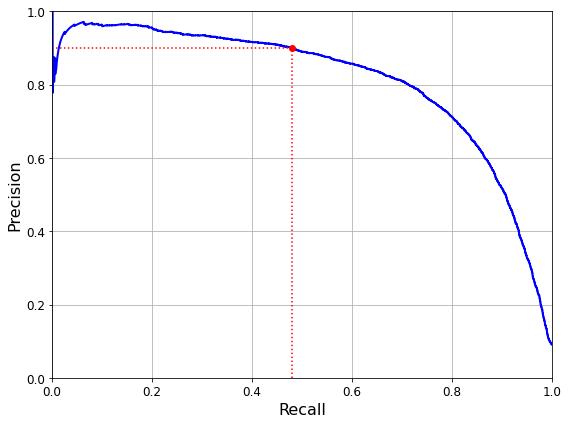

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

The precision really starts to fall sharply around 80% recall. It is possible to select a precision/recall trade-off just before that drop, at around 60% recall.

In case we are interested in having 90% precision, you need to use a threshold of about 8000. You can search for the lowest threshold that gives you at least 90% precision.

In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
threshold_90_precision

3370.0194991439557

In [47]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

90% precision classifier, but 48% recall classifier.

### 5.5 The ROC Curve <a class='anchor' id='roc'></a>

The `receiver operating characteristic (ROC)` curve is another metric for binary classifier. The curve plots the `true positive rate (TPR)` against the `false positive rate (FPR)`.
* FPR is the ratio of negative instances that are incorrectly classified as positive.
* FPR = 1-TNR
* TNR is the ratio of negative instances that are correctly classified as negative.
* TNR is also called `specificity`.
ROC plots sensitivitiy (i.e. recall) versus 1-specificity (1-TNR).

The `roc_curve()` function computes the FPR and FPR for various threshold values.

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

You can plot the FPR against the TPR using matplotlib.

Saving figure roc_curve_plot


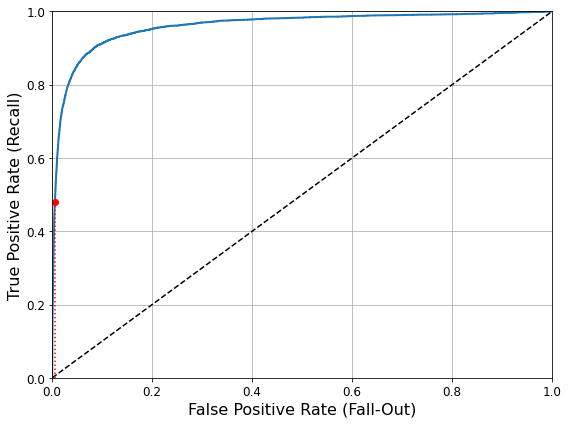

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

There is a trade off: the higher the recall `TPR`, the more false positives `FPR` the classifer produces.
* the back dotted line is the ROC curve of a random classifier
* a good classifier stays as far away from that line as possible (toward the top-left corner)
* the red circle highlights the chosen ratio (at 48% recall)
According to the plot, the classifier seems to be good, but the result is related to few positives (5s) compared to the negatives (non-5s).

To compare classifiers you can measure the area under the curve (AUC).
* a perfect classifier will have a ROC AUC equal to 1
* a purely random classifier will have a ROC AUC equal to 0.5

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

The ROC curve is similar to the precision/recall (PR) curve. It is preferable the PR curve:
* whenever the positive class is rare or 
* when you care more about the false positives than the false negatives
Otherwise you can use the ROC curve.

## 6 Compare ML techniques <a class='anchor' id='compare'></a>

Let's try a Random Forest Classifier and compare its ROC curve and ROC AUC score to those of the stochastic gradient descent (SGD) Classifier. 

The Random Forest does not have a `decision_function()`, it has a `predict_proba()` function that returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g. 70% chance that the image represents a 5).

**Note**: we set `n_estimators` (i.e. the number of trees in the forest) equal to 100 (as default value).

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

This time the `roc_curve()` function uses the positive class's probability as the score. 

In [54]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


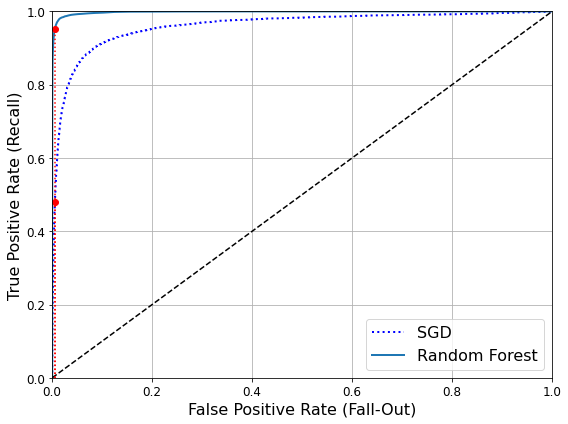

In [55]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

The Random Forest classifier is superior to the SGC classifier, because its ROC curve is much closer to the top-left corner and it has a greater AUC.

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The ROC AUC score is much better than before with the Random Forest. 

In [57]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

We got 99% precision and 86.6% recall.

## 7 Multiclass Classification <a class='anchor' id='multi_class'></a>

Multiclass classifiers can distinguish between more than two classes. 
* Algorithms such as SGD and Random Forest are able to handle multiple classes. 
* Others are strictly binary classifiers, such as logistic regression and Support Vector Machine.

It is possible to use 10 binary classifiers to classify the digit images into 10 classes according to the `one versus the rest strategy`:
* One classifier per each digit
* To classify an image, you get the decision score from each classifier and select the class whose classifier outputs the highest score.

Let's use a Support Vector Machine classifier.

In [59]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

The highest score is the one corresponding to class 5.

In [61]:
np.argmax(some_digit_scores)

5

The `classes_` variable stores the list of target classes ordered by value.

In [62]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [63]:
svm_clf.classes_[5]

5

It is possible to use this approach by using directly the `OneVsOneClassifier()` function. 

In [64]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
len(ovr_clf.estimators_)

10

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [67]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 8 Error Analysis <a class='anchor' id='error'></a>

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [71]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


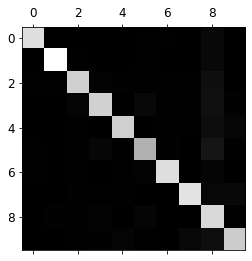

In [72]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [73]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


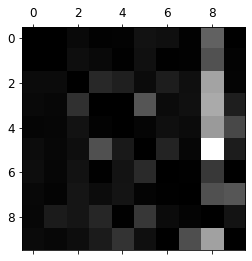

In [74]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


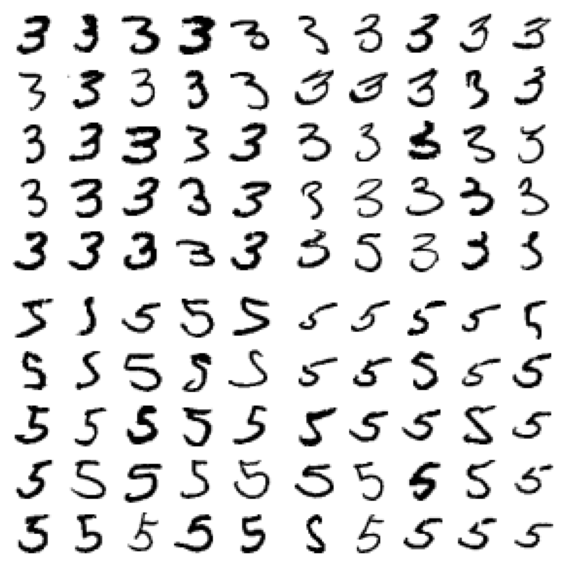

In [75]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); pltd.plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); pltd.plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); pltd.plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); pltd.plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## 9 Multilabel Classification <a class='anchor' id='multi_label'></a>

In [76]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [80]:
y_knn_pred = knn_clf.predict(X_test)

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

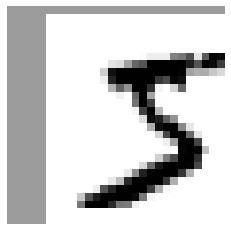

In [82]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [83]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [84]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [85]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [86]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [87]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

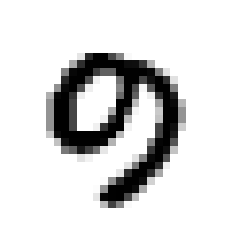

In [88]:
plot_digit(ambiguous_digit)